In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random

In [2]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [3]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the data, default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    last_sequence = np.array(last_sequence)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                               test_size=test_size, shuffle=shuffle)
    # return the result
    return result

In [4]:
def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [5]:
# Window size or the sequence length
N_STEPS = 70
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 400
# Tesla stock market
ticker = "DKNG"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [6]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [7]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)
model.save(os.path.join("results", model_name) + ".h5")

Train on 174 samples, validate on 44 samples
Epoch 1/400
128/174 [=====================>........] - ETA: 2s - loss: 0.0612 - mean_absolute_error: 0.2481 
Epoch 00001: val_loss improved from inf to 0.02147, saving model to results\2020-09-14_DKNG-huber_loss-adam-LSTM-seq-70-step-1-layers-3-units-256.h5
174/174 [==============================] - 9s 53ms/sample - loss: 0.0523 - mean_absolute_error: 0.2292 - val_loss: 0.0215 - val_mean_absolute_error: 0.1451
Epoch 2/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0196 - mean_absolute_error: 0.1457
Epoch 00002: val_loss improved from 0.02147 to 0.01921, saving model to results\2020-09-14_DKNG-huber_loss-adam-LSTM-seq-70-step-1-layers-3-units-256.h5
174/174 [==============================] - 1s 3ms/sample - loss: 0.0188 - mean_absolute_error: 0.1398 - val_loss: 0.0192 - val_mean_absolute_error: 0.1382
Epoch 3/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0224 - mean_absolute_error: 0.1515
Epoch 00003: val_

Epoch 00022: val_loss did not improve from 0.00453
174/174 [==============================] - 0s 3ms/sample - loss: 0.0068 - mean_absolute_error: 0.0832 - val_loss: 0.0068 - val_mean_absolute_error: 0.0836
Epoch 23/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0916
Epoch 00023: val_loss improved from 0.00453 to 0.00361, saving model to results\2020-09-14_DKNG-huber_loss-adam-LSTM-seq-70-step-1-layers-3-units-256.h5
174/174 [==============================] - 0s 3ms/sample - loss: 0.0072 - mean_absolute_error: 0.0848 - val_loss: 0.0036 - val_mean_absolute_error: 0.0575
Epoch 24/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0909
Epoch 00024: val_loss did not improve from 0.00361
174/174 [==============================] - 0s 3ms/sample - loss: 0.0086 - mean_absolute_error: 0.0952 - val_loss: 0.0037 - val_mean_absolute_error: 0.0585
Epoch 25/400
128/174 [=====================>........] - ETA: 0

128/174 [=====================>........] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.0604
Epoch 00045: val_loss did not improve from 0.00111
174/174 [==============================] - 0s 3ms/sample - loss: 0.0035 - mean_absolute_error: 0.0570 - val_loss: 0.0011 - val_mean_absolute_error: 0.0312
Epoch 46/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0476
Epoch 00046: val_loss did not improve from 0.00111
174/174 [==============================] - 0s 3ms/sample - loss: 0.0028 - mean_absolute_error: 0.0484 - val_loss: 0.0022 - val_mean_absolute_error: 0.0433
Epoch 47/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0567
Epoch 00047: val_loss improved from 0.00111 to 0.00107, saving model to results\2020-09-14_DKNG-huber_loss-adam-LSTM-seq-70-step-1-layers-3-units-256.h5
174/174 [==============================] - 1s 3ms/sample - loss: 0.0033 - mean_absolute_error: 0.0556 - val_loss: 0.0011 

128/174 [=====================>........] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.0446
Epoch 00069: val_loss did not improve from 0.00071
174/174 [==============================] - 0s 3ms/sample - loss: 0.0019 - mean_absolute_error: 0.0428 - val_loss: 0.0012 - val_mean_absolute_error: 0.0326
Epoch 70/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0430
Epoch 00070: val_loss did not improve from 0.00071
174/174 [==============================] - 0s 3ms/sample - loss: 0.0018 - mean_absolute_error: 0.0419 - val_loss: 8.8124e-04 - val_mean_absolute_error: 0.0272
Epoch 71/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0440
Epoch 00071: val_loss did not improve from 0.00071
174/174 [==============================] - 0s 3ms/sample - loss: 0.0022 - mean_absolute_error: 0.0426 - val_loss: 9.6368e-04 - val_mean_absolute_error: 0.0291
Epoch 72/400
128/174 [=====================>........] - ETA:

128/174 [=====================>........] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0388
Epoch 00094: val_loss did not improve from 0.00066
174/174 [==============================] - 0s 3ms/sample - loss: 0.0017 - mean_absolute_error: 0.0406 - val_loss: 8.7639e-04 - val_mean_absolute_error: 0.0284
Epoch 95/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.0383
Epoch 00095: val_loss did not improve from 0.00066
174/174 [==============================] - 0s 3ms/sample - loss: 0.0017 - mean_absolute_error: 0.0389 - val_loss: 6.7366e-04 - val_mean_absolute_error: 0.0240
Epoch 96/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0429
Epoch 00096: val_loss did not improve from 0.00066
174/174 [==============================] - 1s 3ms/sample - loss: 0.0024 - mean_absolute_error: 0.0454 - val_loss: 8.2632e-04 - val_mean_absolute_error: 0.0280
Epoch 97/400
128/174 [=====================>........] - 

Epoch 119/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.0373
Epoch 00119: val_loss did not improve from 0.00062
174/174 [==============================] - 0s 3ms/sample - loss: 0.0014 - mean_absolute_error: 0.0378 - val_loss: 7.9061e-04 - val_mean_absolute_error: 0.0275
Epoch 120/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.0367    
Epoch 00120: val_loss improved from 0.00062 to 0.00058, saving model to results\2020-09-14_DKNG-huber_loss-adam-LSTM-seq-70-step-1-layers-3-units-256.h5
174/174 [==============================] - 1s 4ms/sample - loss: 0.0016 - mean_absolute_error: 0.0375 - val_loss: 5.8474e-04 - val_mean_absolute_error: 0.0220
Epoch 121/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0348
Epoch 00121: val_loss did not improve from 0.00058
174/174 [==============================] - 1s 3ms/sample - loss: 0.0012 - mean_absolute_error

Epoch 142/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0335
Epoch 00142: val_loss did not improve from 0.00048
174/174 [==============================] - 0s 3ms/sample - loss: 0.0012 - mean_absolute_error: 0.0343 - val_loss: 8.6494e-04 - val_mean_absolute_error: 0.0285
Epoch 143/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0342    
Epoch 00143: val_loss did not improve from 0.00048
174/174 [==============================] - 0s 3ms/sample - loss: 0.0012 - mean_absolute_error: 0.0344 - val_loss: 5.5629e-04 - val_mean_absolute_error: 0.0227
Epoch 144/400
128/174 [=====================>........] - ETA: 0s - loss: 8.9185e-04 - mean_absolute_error: 0.0307
Epoch 00144: val_loss did not improve from 0.00048
174/174 [==============================] - 0s 3ms/sample - loss: 0.0011 - mean_absolute_error: 0.0346 - val_loss: 5.3347e-04 - val_mean_absolute_error: 0.0220
Epoch 145/400
128/174 [=========

Epoch 167/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0318
Epoch 00167: val_loss did not improve from 0.00044
174/174 [==============================] - 0s 3ms/sample - loss: 0.0013 - mean_absolute_error: 0.0352 - val_loss: 4.7135e-04 - val_mean_absolute_error: 0.0212
Epoch 168/400
128/174 [=====================>........] - ETA: 0s - loss: 9.5529e-04 - mean_absolute_error: 0.0314
Epoch 00168: val_loss improved from 0.00044 to 0.00042, saving model to results\2020-09-14_DKNG-huber_loss-adam-LSTM-seq-70-step-1-layers-3-units-256.h5
174/174 [==============================] - 1s 3ms/sample - loss: 9.8327e-04 - mean_absolute_error: 0.0319 - val_loss: 4.2369e-04 - val_mean_absolute_error: 0.0197
Epoch 169/400
128/174 [=====================>........] - ETA: 0s - loss: 9.8637e-04 - mean_absolute_error: 0.0319
Epoch 00169: val_loss improved from 0.00042 to 0.00041, saving model to results\2020-09-14_DKNG-huber_loss-adam-LSTM-seq-70-step-1-layer

128/174 [=====================>........] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0342
Epoch 00191: val_loss did not improve from 0.00037
174/174 [==============================] - 0s 3ms/sample - loss: 0.0011 - mean_absolute_error: 0.0328 - val_loss: 6.3954e-04 - val_mean_absolute_error: 0.0222
Epoch 192/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.0379
Epoch 00192: val_loss did not improve from 0.00037
174/174 [==============================] - 0s 3ms/sample - loss: 0.0012 - mean_absolute_error: 0.0342 - val_loss: 5.4463e-04 - val_mean_absolute_error: 0.0220
Epoch 193/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0333
Epoch 00193: val_loss did not improve from 0.00037
174/174 [==============================] - 0s 3ms/sample - loss: 0.0010 - mean_absolute_error: 0.0319 - val_loss: 5.1002e-04 - val_mean_absolute_error: 0.0217
Epoch 194/400
128/174 [=====================>........]

Epoch 216/400
128/174 [=====================>........] - ETA: 0s - loss: 9.2364e-04 - mean_absolute_error: 0.0316
Epoch 00216: val_loss did not improve from 0.00036
174/174 [==============================] - 1s 3ms/sample - loss: 0.0010 - mean_absolute_error: 0.0323 - val_loss: 4.1256e-04 - val_mean_absolute_error: 0.0191
Epoch 217/400
128/174 [=====================>........] - ETA: 0s - loss: 8.7662e-04 - mean_absolute_error: 0.0315
Epoch 00217: val_loss did not improve from 0.00036
174/174 [==============================] - 1s 3ms/sample - loss: 9.3103e-04 - mean_absolute_error: 0.0314 - val_loss: 3.7330e-04 - val_mean_absolute_error: 0.0189
Epoch 218/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0326    
Epoch 00218: val_loss did not improve from 0.00036
174/174 [==============================] - 0s 3ms/sample - loss: 0.0012 - mean_absolute_error: 0.0333 - val_loss: 3.6713e-04 - val_mean_absolute_error: 0.0195
Epoch 219/400
128/174 [=

Epoch 241/400
128/174 [=====================>........] - ETA: 0s - loss: 9.8798e-04 - mean_absolute_error: 0.0323
Epoch 00241: val_loss did not improve from 0.00030
174/174 [==============================] - 0s 3ms/sample - loss: 9.7522e-04 - mean_absolute_error: 0.0325 - val_loss: 3.1214e-04 - val_mean_absolute_error: 0.0170
Epoch 242/400
128/174 [=====================>........] - ETA: 0s - loss: 9.3328e-04 - mean_absolute_error: 0.0304
Epoch 00242: val_loss did not improve from 0.00030
174/174 [==============================] - 0s 3ms/sample - loss: 8.8051e-04 - mean_absolute_error: 0.0298 - val_loss: 3.5175e-04 - val_mean_absolute_error: 0.0182
Epoch 243/400
128/174 [=====================>........] - ETA: 0s - loss: 6.8988e-04 - mean_absolute_error: 0.0276
Epoch 00243: val_loss did not improve from 0.00030
174/174 [==============================] - 0s 3ms/sample - loss: 8.3411e-04 - mean_absolute_error: 0.0299 - val_loss: 5.7802e-04 - val_mean_absolute_error: 0.0239
Epoch 244/400
12

128/174 [=====================>........] - ETA: 0s - loss: 5.6960e-04 - mean_absolute_error: 0.0248
Epoch 00266: val_loss did not improve from 0.00030
174/174 [==============================] - 0s 3ms/sample - loss: 7.4799e-04 - mean_absolute_error: 0.0276 - val_loss: 4.0526e-04 - val_mean_absolute_error: 0.0201
Epoch 267/400
128/174 [=====================>........] - ETA: 0s - loss: 7.8406e-04 - mean_absolute_error: 0.0280
Epoch 00267: val_loss did not improve from 0.00030
174/174 [==============================] - 0s 3ms/sample - loss: 8.1125e-04 - mean_absolute_error: 0.0289 - val_loss: 3.7498e-04 - val_mean_absolute_error: 0.0194
Epoch 268/400
128/174 [=====================>........] - ETA: 0s - loss: 7.0467e-04 - mean_absolute_error: 0.0289
Epoch 00268: val_loss did not improve from 0.00030
174/174 [==============================] - 0s 3ms/sample - loss: 7.1616e-04 - mean_absolute_error: 0.0286 - val_loss: 3.7791e-04 - val_mean_absolute_error: 0.0183
Epoch 269/400
128/174 [=======

128/174 [=====================>........] - ETA: 0s - loss: 7.5711e-04 - mean_absolute_error: 0.0272
Epoch 00291: val_loss improved from 0.00030 to 0.00028, saving model to results\2020-09-14_DKNG-huber_loss-adam-LSTM-seq-70-step-1-layers-3-units-256.h5
174/174 [==============================] - 0s 3ms/sample - loss: 7.4107e-04 - mean_absolute_error: 0.0278 - val_loss: 2.7962e-04 - val_mean_absolute_error: 0.0168
Epoch 292/400
128/174 [=====================>........] - ETA: 0s - loss: 8.0675e-04 - mean_absolute_error: 0.0273
Epoch 00292: val_loss did not improve from 0.00028
174/174 [==============================] - 0s 3ms/sample - loss: 7.7538e-04 - mean_absolute_error: 0.0273 - val_loss: 3.8578e-04 - val_mean_absolute_error: 0.0194
Epoch 293/400
128/174 [=====================>........] - ETA: 0s - loss: 8.1782e-04 - mean_absolute_error: 0.0281
Epoch 00293: val_loss did not improve from 0.00028
174/174 [==============================] - 0s 3ms/sample - loss: 8.5152e-04 - mean_absolute

Epoch 316/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0307
Epoch 00316: val_loss did not improve from 0.00028
174/174 [==============================] - 1s 3ms/sample - loss: 9.5165e-04 - mean_absolute_error: 0.0301 - val_loss: 3.9559e-04 - val_mean_absolute_error: 0.0190
Epoch 317/400
128/174 [=====================>........] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0329    
Epoch 00317: val_loss did not improve from 0.00028
174/174 [==============================] - 0s 3ms/sample - loss: 0.0011 - mean_absolute_error: 0.0317 - val_loss: 3.4899e-04 - val_mean_absolute_error: 0.0190
Epoch 318/400
128/174 [=====================>........] - ETA: 0s - loss: 7.1517e-04 - mean_absolute_error: 0.0268
Epoch 00318: val_loss did not improve from 0.00028
174/174 [==============================] - 1s 3ms/sample - loss: 7.1312e-04 - mean_absolute_error: 0.0273 - val_loss: 3.8145e-04 - val_mean_absolute_error: 0.0187
Epoch 319/400
128/174 [=

Epoch 341/400
128/174 [=====================>........] - ETA: 0s - loss: 6.0994e-04 - mean_absolute_error: 0.0254
Epoch 00341: val_loss did not improve from 0.00028
174/174 [==============================] - 0s 3ms/sample - loss: 7.1652e-04 - mean_absolute_error: 0.0273 - val_loss: 2.9202e-04 - val_mean_absolute_error: 0.0184
Epoch 342/400
128/174 [=====================>........] - ETA: 0s - loss: 8.9751e-04 - mean_absolute_error: 0.0289
Epoch 00342: val_loss did not improve from 0.00028
174/174 [==============================] - 1s 3ms/sample - loss: 8.2578e-04 - mean_absolute_error: 0.0284 - val_loss: 3.5286e-04 - val_mean_absolute_error: 0.0190
Epoch 343/400
128/174 [=====================>........] - ETA: 0s - loss: 5.6735e-04 - mean_absolute_error: 0.0249
Epoch 00343: val_loss did not improve from 0.00028
174/174 [==============================] - 0s 3ms/sample - loss: 6.0751e-04 - mean_absolute_error: 0.0258 - val_loss: 4.2048e-04 - val_mean_absolute_error: 0.0209
Epoch 344/400
12

Epoch 366/400
128/174 [=====================>........] - ETA: 0s - loss: 5.9139e-04 - mean_absolute_error: 0.0253
Epoch 00366: val_loss did not improve from 0.00028
174/174 [==============================] - 0s 3ms/sample - loss: 6.4460e-04 - mean_absolute_error: 0.0268 - val_loss: 3.3386e-04 - val_mean_absolute_error: 0.0189
Epoch 367/400
128/174 [=====================>........] - ETA: 0s - loss: 7.2380e-04 - mean_absolute_error: 0.0267
Epoch 00367: val_loss did not improve from 0.00028
174/174 [==============================] - 0s 2ms/sample - loss: 6.3908e-04 - mean_absolute_error: 0.0251 - val_loss: 3.3584e-04 - val_mean_absolute_error: 0.0178
Epoch 368/400
128/174 [=====================>........] - ETA: 0s - loss: 6.7242e-04 - mean_absolute_error: 0.0257
Epoch 00368: val_loss did not improve from 0.00028
174/174 [==============================] - 0s 3ms/sample - loss: 7.1730e-04 - mean_absolute_error: 0.0272 - val_loss: 3.4753e-04 - val_mean_absolute_error: 0.0185
Epoch 369/400
12

Epoch 391/400
128/174 [=====================>........] - ETA: 0s - loss: 6.0694e-04 - mean_absolute_error: 0.0257
Epoch 00391: val_loss did not improve from 0.00028
174/174 [==============================] - 0s 3ms/sample - loss: 6.1515e-04 - mean_absolute_error: 0.0260 - val_loss: 3.2436e-04 - val_mean_absolute_error: 0.0164
Epoch 392/400
128/174 [=====================>........] - ETA: 0s - loss: 7.5835e-04 - mean_absolute_error: 0.0275
Epoch 00392: val_loss did not improve from 0.00028
174/174 [==============================] - 0s 3ms/sample - loss: 6.5886e-04 - mean_absolute_error: 0.0261 - val_loss: 3.6526e-04 - val_mean_absolute_error: 0.0202
Epoch 393/400
128/174 [=====================>........] - ETA: 0s - loss: 5.7078e-04 - mean_absolute_error: 0.0268
Epoch 00393: val_loss did not improve from 0.00028
174/174 [==============================] - 0s 3ms/sample - loss: 5.7603e-04 - mean_absolute_error: 0.0263 - val_loss: 3.7338e-04 - val_mean_absolute_error: 0.0197
Epoch 394/400
12

In [8]:
tensorboard --logdir="logs"

SyntaxError: can't assign to operator (<ipython-input-8-87357480c861>, line 1)

In [9]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [10]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
print("Mean Absolute Error:", mean_absolute_error)

Mean Absolute Error: 10.575113429006645


In [11]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price

In [12]:
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

Future price after 1 days is 41.29$


In [13]:
def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    # last 200 days, feel free to edit that
    plt.plot(y_test[-200:], c='b')
    plt.plot(y_pred[-200:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

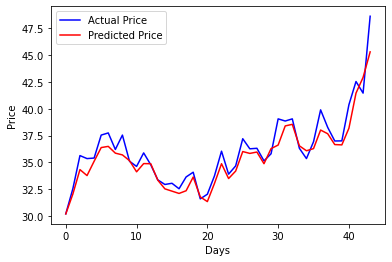

In [14]:
plot_graph(model, data)

In [15]:
def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)

In [16]:
print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))

1: Accuracy Score: 0.7441860465116279
